# Percentile results
This notebook reflects the results obtained for the psycho network

In [137]:
import os, sys
sys.path.insert(0, '../')
from matplotlib import style
style.use('seaborn-poster')
from Utils import stats, IO
import matplotlib.pyplot as plt, numpy as np, scipy,\
networkx as nx
fn = 'data2019-11-11T11:16:28.427495.pickle'
fn = 'data2019-11-17T10:00:22.689166.pickle'
fn = 'data2019-11-18T13:29:47.801887.pickle'
for k,v in IO.loadPickle(fn).items():
    globals()[k] = v
    print(f'Loading {k}')

    
centralities = dict(\
                   degree = nx.degree_centrality,\
                   betweenness = nx.betweenness_centrality,\
                   closeness  = nx.closeness_centrality,\
                   eigenvector = nx.eigenvector_centrality,\
                   )
conditions = len(centralities) + 1
# print(settings)

%matplotlib widget
# print(settings.values())
# fn = '../Data//2019-11-18T09:29:52.086011/settings.pickle'
# for k, v in IO.loadPickle(fn).items():
#     print(k, v)

Loading aucs
Loading data
Loading rata
Loading settings
Loading coeffs


In [99]:
%load_ext autoreload
%autoreload 2
DRIVERS = {}
alpha = .01
from tqdm import tqdm_notebook as tqdm
from Utils.stats import bootStrapDrivers
N, n = int(1e4), 1000

N = int(1e4)
# for all aucs

# from Utils.stats import bootStrapThresholds
alphas = np.linspace(0.1, 1, 10)
alphas  = np.array([0, .05])
structuralData = {}
for k, setting in settings.items():
    m = setting.get('model')
    g = m.graph
    
    buffer = np.zeros((m.nNodes))
    centData = {}
    for condition, cf in centralities.items():
        c = cf(g)
        for node, val in c.items():
            idx = m.mapping[node]
            buffer[idx] = val
        MAX = buffer.max()
        cdrivers = np.where(buffer == MAX)[0]
        centData[condition] = cdrivers
    structuralData[k] = centData
    
from Utils.stats import returnX
from itertools import product


from Utils.stats import bootStrapAll
boots = {}
alldrivers = {}
total = int(1e4)
batch = int(1e2)
alpha = .5
for k, v in aucs.items():
    v = np.moveaxis(v, 0, 1) # swap trials and nodes
    print(v.shape)
    alldrivers[k] = bootStrapAll(v, returnX, total, batch, alpha)
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(20, 12, 5, 3)


In [95]:
from Utils.stats import computeMatchScore
for k, v in alldrivers.items():
    tmp = np.array([i[1] for i in v.flat], dtype = dict).reshape(v.shape)
    print(tmp.shape)
    overlap = computeMatchScore(tmp)

npulse, ntemp = overlap.shape
xr = np.arange(ntemp)
width = 1 / npulse

pulses = ['inf. impact', *settings[k].get('pulseSizes')]

fig, ax = plt.subplots()
for condition in range(1, npulse):
    ax.bar(xr + condition * width, overlap[condition], \
           width = width,\
           label = pulses[condition])
ax.legend()
fig.show()




(5, 3)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/casper/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/casper/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:206: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-7-7dc0639e4082>:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


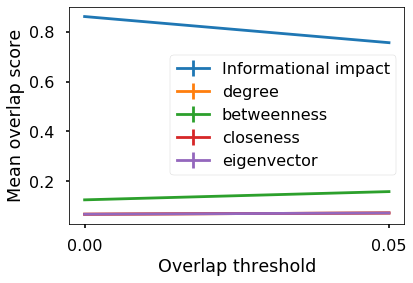

(1, 12, 20, 5, 3)
(5, 3)


IndexError: too many indices for array

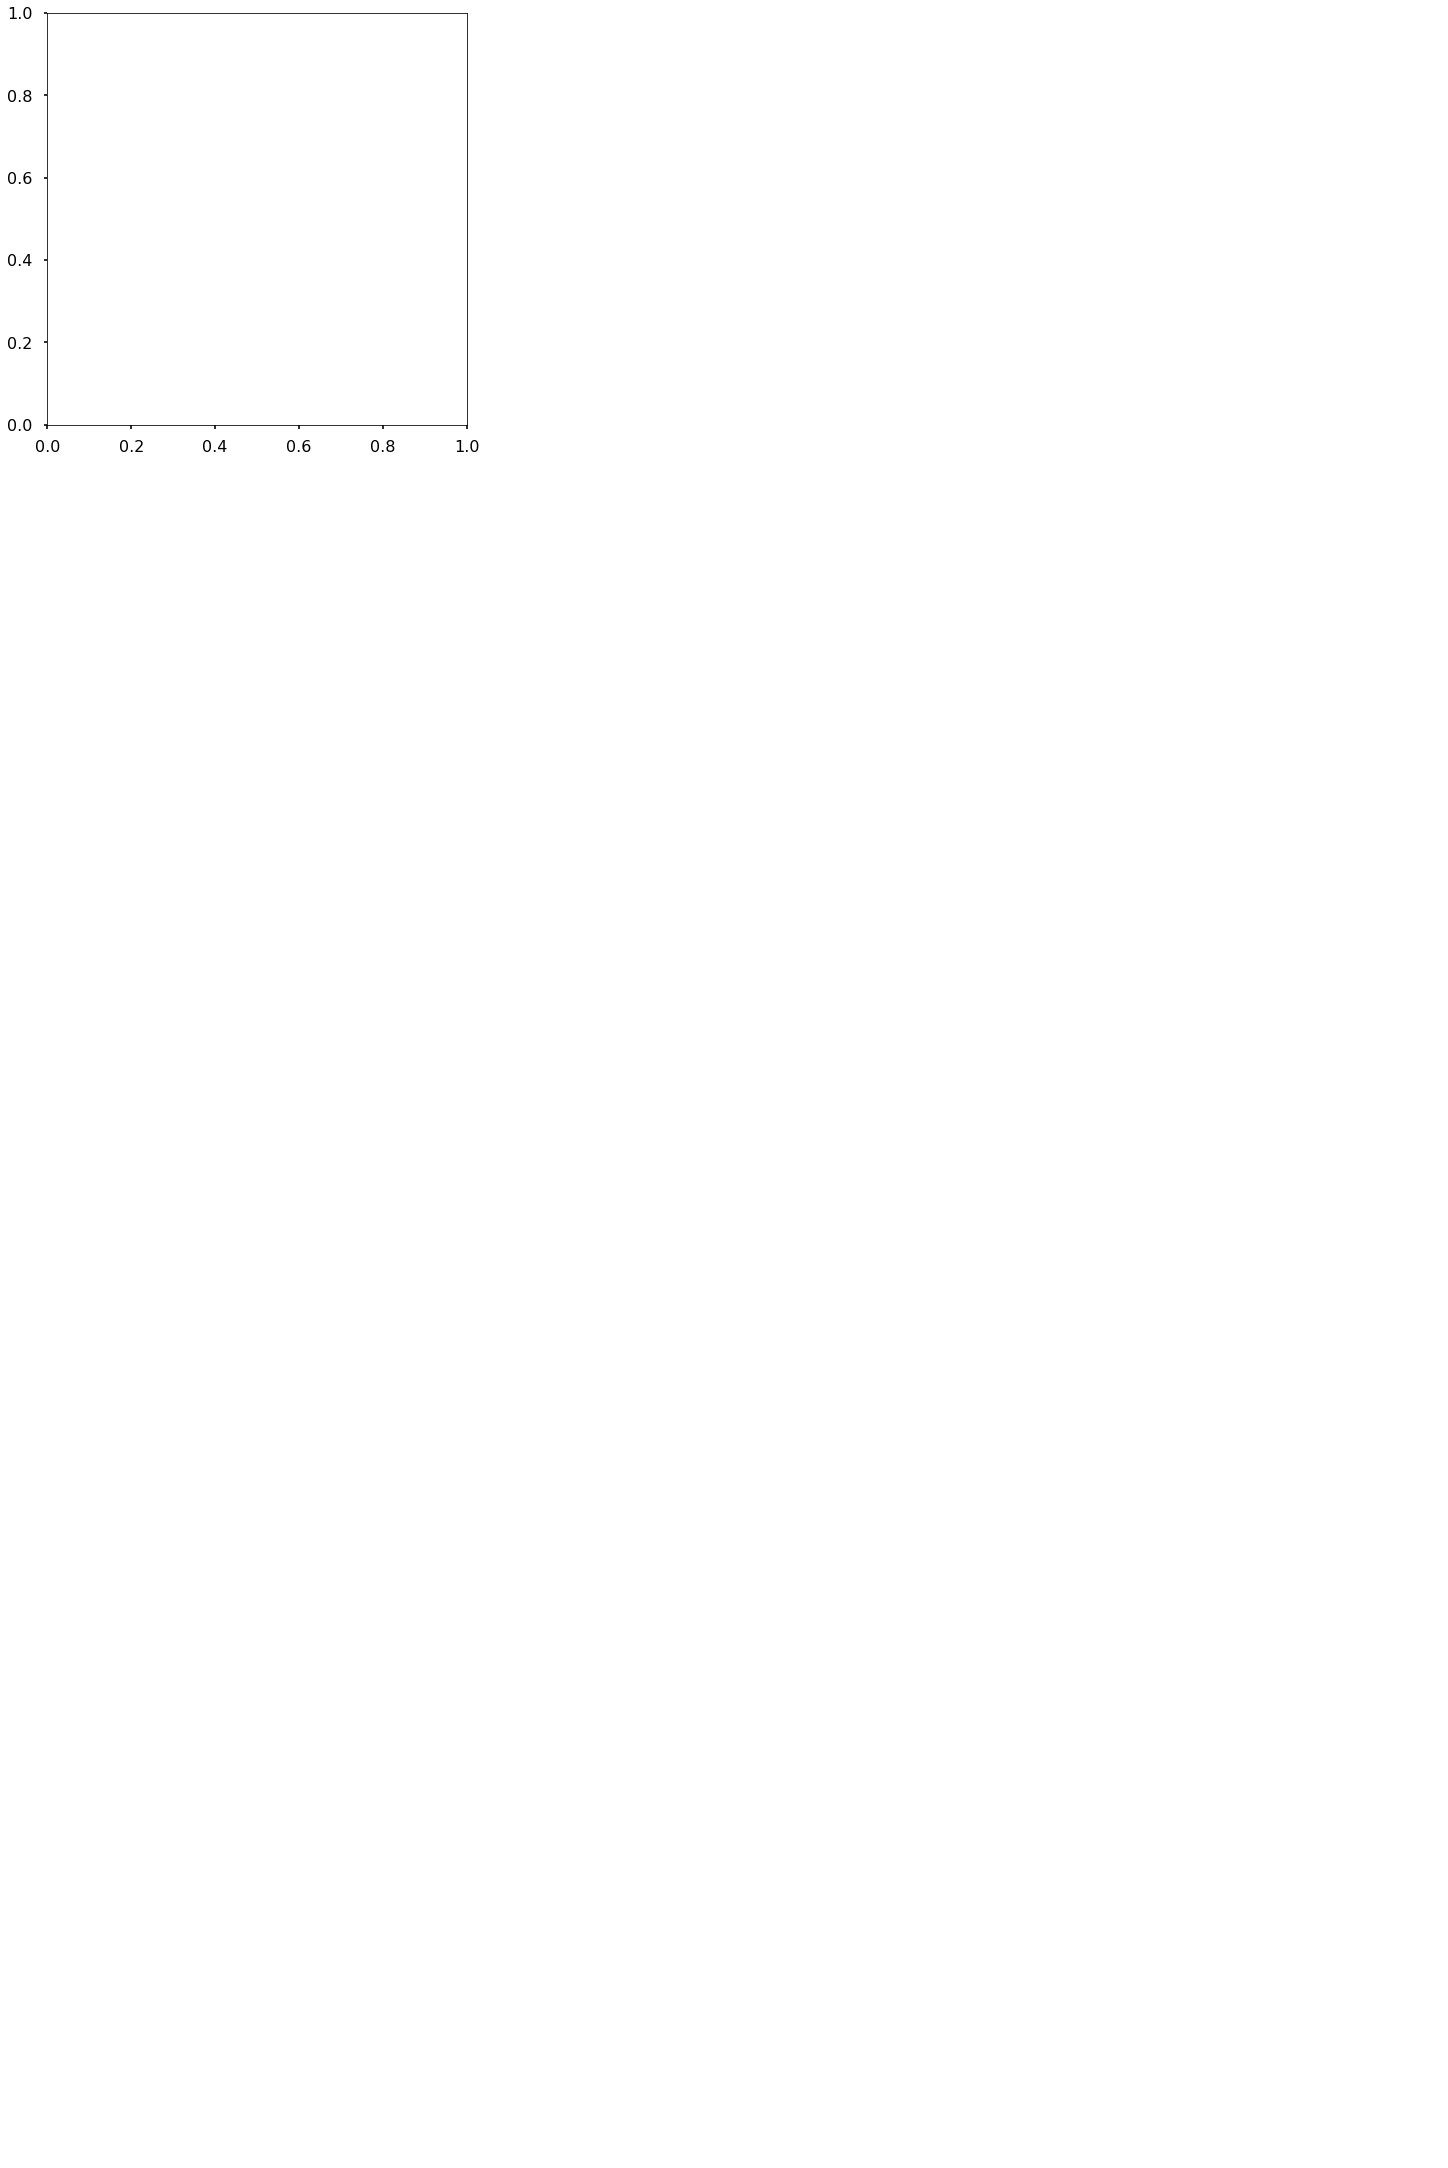

In [21]:
setting = next(iter(settings.values()))
overlaps = np.array([i.get(bestAlpha).get('overlaps') for i in alphaData.values()])
ALLDRIVERS = {k : i.get(bestAlpha).get('ALLDRIVERS') for k, i in alphaData.items()}
driverSizes = np.array([i.get(bestAlpha).get('driverSizes') for i in alphaData.values()])


pulses = np.array(setting.get('pulseSizes'))
npulse = pulses.size + 1
ntemp  = len(setting.get('equilibrium')['ratios'])


from itertools import product
overlaps = np.zeros((len(aucs), npulse, ntemp, conditions))

driverSizes = np.zeros((len(aucs), npulse, ntemp))
centSizes = np.zeros((len(aucs), conditions))
for dataidx, (k, v) in enumerate(ALLDRIVERS.items()):
    controls = v[..., 0]
    centSizes[dataidx] = [len(i) for i in v[0, 0, :]]
    for (pulse, temp, condition) in product(*map(range, (v.shape))):
        a = np.array(v[0, temp, condition]).flat
        b = np.array(controls[pulse, temp]).flat
        a, b  = set(a), set(b)
        overlaps[dataidx, pulse, temp, condition] = len(a.intersection(b)) / len(a.union(b))
        
        
        driverSizes[dataidx, pulse, temp] = len(b)

In [13]:
from scipy.stats import sem
tmp = next(iter(data.values()))


nnodes, trials, npulse, ntemp, deltas = tmp.shape
colors = plt.cm.tab20(range(nnodes))
fig, ax = plt.subplots(npulse, ntemp, figsize = (15,10), sharex = 'all',\
                       sharey = 'all')
xr = np.arange(deltas)
for p in range(npulse):
    for t in range(ntemp):
        axi = ax[p, t]
        
        for node in range(nnodes):
            axi.plot(xr, tmp[node, :, p, t, :].mean(0), \
                     color = colors[node],\
                    )
#         axi.set_scale('log')
fig.subplots_adjust(wspace = .05)
fig.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
overlaps = overlaps.squeeze()

from Utils.stats import bootStrap, justReturnX, ratio

N = int(1e5)
Nbc = 1000
boots = bootStrap(overlaps.reshape(-1, conditions), ratio, N, Nbc)
tmp = np.moveaxis(overlaps, 1, 0) + 1e-2
hboots = bootStrap(tmp, ratio, N, Nbc)


In [61]:
# concatenate data
allboots = np.concatenate((hboots, boots[:, None]), axis = 1)

print(boots.shape, hboots.shape, allboots.shape)
_, statconditions, _ = allboots.shape
binned = np.zeros((allboots.shape[1:]), dtype = list)

for idx in range(statconditions):
    for cond in range(conditions - 1):
        tmp = allboots[..., idx, cond]
        c, b = np.histogram(tmp, density = 1, bins = 50)
        b = (b[:-1] + b[1:]) / 2
        binned[idx, cond] = [b, c]


(100000, 4) (100000, 11, 4) (100000, 12, 4)


<ipython-input-75-f9ff8f8c5309>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


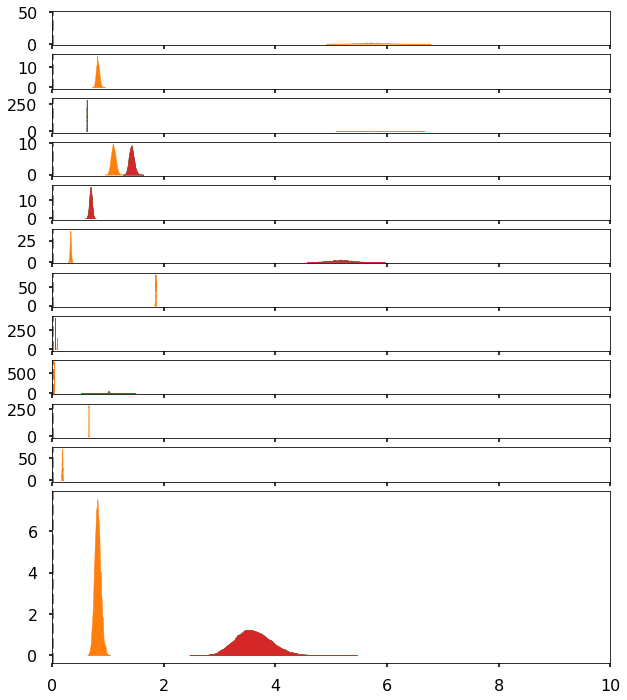

In [75]:
%matplotlib inline

hs = np.ones(statconditions)
hs[-1] = 5

gs = dict(height_ratios = hs)
fig, ax = plt.subplots(statconditions, 1, sharex = 'all',\
                      gridspec_kw = gs,\
                      figsize = (10, 12))

colors = plt.cm.tab10(range(conditions - 1))
for idx, axi in enumerate(ax):
    for cond in range(conditions - 1):
        b, c = binned[idx, cond]
#         print(c.max())
#         c = (c - c.min()) / (c.max() - c.min())
        axi.fill_between(b, 0, c, color = colors[cond])
    axi.set_xlim(0, 10)
    axi.axvline(0, 0, 1, linestyle = 'dashed',\
               color = 'gray')
fig.show()


# Time data widget

In [100]:
%matplotlib notebook
import ipywidgets as widgets
from scipy.stats import sem
from Utils.plotting import addGraphPretty

npulse = 5
# dataSlider = widgets.SelectionSlider(options = data.keys())
dataSlider = widgets.Select(options = data.keys())
tempSlider = widgets.IntSlider(min = 0, max = 2)


pulseSlider = widgets.IntSlider(min = 1, max = npulse - 1)


%matplotlib widget
fig, (left, right) = plt.subplots(1, 2, figsize = (10, 7), sharey = 'all')
mainax = fig.add_subplot(111, frameon = 0,\
                        xticks = [],\
                        yticks = [])
mainax.set_xlabel('Time[step]', labelpad = 30)
# inax.axis('off')
@widgets.interact(dataName = dataSlider, \
                  temp = tempSlider, \
                  pulse = pulseSlider)
def update(dataName, temp, pulse):
    d = rata.get(dataName)
    
    for idx, i in enumerate(data.keys()):
        if i == dataName:
            break
    drivers = alldrivers[dataName][pulse, temp][0]
    print(drivers)
    mainax.set_title(dataName + "\n" + str(drivers))
    g = settings.get(dataName).get('graph')
    
    nodes, trials, pulses, temps, deltas = d.shape
    colors = plt.cm.tab20(range(nodes))
    means = d.mean(1)
    sems  =  2 * np.std(d, axis = 1)
    xr = np.arange(d.shape[-1])
    
    left.cla(); right.cla()
    
    inax = right.inset_axes([.4, 0.4, .6, .6])
    addGraphPretty(g, ax = inax)
    inax.axis('off')
    for node in range(nodes):
        left.errorbar(xr, means[node, 0, temp], \
                      sems[node, 0, temp], \
                      color = colors[node],\
                      label = node)
        right.errorbar(xr, means[node, pulse, temp], \
                       sems[node, pulse, temp], \
                       color = colors[node],\
                       label = node)
    
    
    elems = [\
             plt.Line2D([], [], color = colors[node], \
                  label = f'{node}{"*" if node in drivers else ""}', \
                  marker = 'o', linestyle = 'None')\
                  for node in range(nodes)\
          ]
    left.set_ylabel(r'$I(s_i^{t_0 + t} ; S^{t_0})$')
    right.set_ylabel(r"$D_{KL}(P' \vert \vert P)$")
    right.legend(handles = elems, \
                 bbox_to_anchor = (1.0, 1), loc = 'upper left',\
                title = 'Node', title_fontsize = 20,\
                frameon = 0,\
                borderaxespad = 0)
    print(dataName)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(Select(description='dataName', options=('Data/psycho/2019-11-18T09:48:58.046043',), valu…

In [138]:
%matplotlib notebook

